# FIT5202 Assignment 1 : Analysing eCommerce Data

## Table of Contents
* 
    * [Part 1 : Working with RDD](#part-1)
        * [1.1 Data Preparation and Loading](#1.1)
        * [1.2 Data Partitioning in RDD](#1.2)
        * [1.3 Query/Analysis](#1.3)
    * [Part 2 : Working with DataFrames](#2-dataframes)
        * [2.1 Data Preparation and Loading](#2-dataframes)
        * [2.2 Query/Analysis](#2.2)
    * [Part 3 :  RDDs vs DataFrame vs Spark SQL](#part-3)

# Part 1 : Working with RDDs <a class="anchor" name="part-1"></a>
## 1.1 Working with RDD
In this section, you will need to create RDDs from the given datasets, perform partitioning in these RDDs and use various RDD operations to answer the queries for retail analysis. 

### 1.1.1 Data Preparation and Loading <a class="anchor" name="1.1"></a>
Write the code to create a SparkContext object using SparkSession. To create a SparkSession you first need to build a SparkConf object that contains information about your application, use Melbourne time as the session timezone. Give an appropriate name for your application and run Spark locally with as many working processors as logical cores on your machine. 

In [85]:
# Import SparkConf class into program
from pyspark import SparkConf

# local[*]: run Spark in local mode with as many working processors as logical cores on your machine
# If we want Spark to run locally with 'k' worker threads, we can specify as "local[k]".
# master = "local[*]"
master="local[4]"
# The `appName` field is a name to be shown on the Spark cluster UI page
app_name = "Assignment1"
# Setup configuration parameters for Spark
spark_conf = SparkConf().setMaster(master).setAppName(app_name)

# Set the session timezone to Melbourne time
spark_conf.set("spark.sql.session.timeZone", "Australia/Melbourne")

#TODO : Initialize Spark Session and create a SparkContext Object
# Import SparkContext and SparkSession classes
from pyspark import SparkContext # Spark
from pyspark.sql import SparkSession # Spark SQL

spark= SparkSession.builder.config(conf=spark_conf).getOrCreate()
sc=spark.sparkContext
sc.setLogLevel('ERROR')


1.1.2 Load CUPS csv files into four RDDs.

In [86]:
# Load All CSV to 4 RDD

category_rdd = sc.textFile('category.csv')

user_rdd = sc.textFile('users.csv')

product_rdd = sc.textFile('product.csv')

sales_rdd = sc.textFile('sales.csv')

1.1.3 For each RDD, remove the header rows and display the total count and first 10 records. (Hint: You can use csv.reader to parse rows into RDDs.)

In [87]:
import csv
# Function to remove header
def remove_header(header):
    for row in csv.reader(header):
        if row != header:
            yield row
# Get the header of each rdd
header_category=category_rdd.first()
header_user=user_rdd.first()
header_product=product_rdd.first()
header_sales=sales_rdd.first()

# Create dictionaries to save header and  index of each column
column_category = header_category.split(',')
column_name_category = {column_name: str(index) for index, column_name in enumerate(column_category)}

column_user = header_user.split(',')
column_name_user = {column_name: str(index) for index, column_name in enumerate(column_user)}

column_product = header_product.split(',')
column_name_product = {column_name: str(index) for index, column_name in enumerate(column_product)}

column_sales = header_sales.split(',')
column_name_sales = {column_name: str(index) for index, column_name in enumerate(column_sales)}


# Remove the header and parse rows into RDD using csv.reader
category_rdd = category_rdd.filter(lambda row: row != header_category).mapPartitions(remove_header)
user_rdd = user_rdd.filter(lambda row: row !=header_user).mapPartitions(remove_header)
product_rdd = product_rdd.filter(lambda row: row != header_product).mapPartitions(remove_header)
sales_rdd = sales_rdd.filter(lambda row: row != header_sales).mapPartitions(remove_header)

#total count and first 10 records
print("Total Count of Category :",category_rdd.count())
print(category_rdd.take(10))

print("Total Count of User :",user_rdd.count())
print(user_rdd.take(10))

print("Total Count of Product :",product_rdd.count())
print(product_rdd.take(10))

print("Total Count of Sales :",sales_rdd.count())                                                                                   
print(sales_rdd.take(10))

Total Count of Category : 1464
[['2090971686529663114', 'appliances.environment.vacuum'], ['2232732116498514828', 'apparel.jeans'], ['2232732109628244704', 'apparel.shirt'], ['2232732103294845523', 'apparel.shoes.step_ins'], ['2232732086500851925', 'apparel.scarf'], ['2232732100660822557', 'country_yard.cultivator'], ['2053013558282682943', 'construction.tools.drill'], ['2053013562527318829', 'furniture.living_room.cabinet'], ['2110937143172923797', 'construction.tools.light'], ['2074462942123786261', 'kids.toys']]
Total Count of User : 15639803
[['514771925', 'MERVYN', 'Unknown', '1-5-1963', '30A LUCINDA AVENUE', '2260', 'NSW', 'male', 'WAMBERAL'], ['531947692', 'FALLON', 'Unknown', '16-10-2002', '82 CAMBERWARRA DRIVE', '6025', 'WA', 'female', 'CRAIGIE'], ['560231306', 'KALIN', 'Unknown', '19-8-2015', '74 SOLDIERS ROAD', '2281', 'NSW', 'male', 'PELICAN'], ['575248835', 'PIETTA', 'Unknown', '19-1-1962', 'UNIT 1, 1 LARK AVENUE', '5023', 'SA', 'female', 'SEATON'], ['575243330', 'SUMMAH',

1.1.4 Drop unnecessary columns from RDDs: firstname, lastname, user_session.

In [88]:

# column index for firstname and lastname
col_index2=[1,2]
# drop column based on col_index
user_rdd = user_rdd.map(lambda row: [value for index, value in enumerate(row) if index not in col_index2])
# show the result
print(user_rdd.take(1))
# column index for user session
col_index=[5]
# drop column based on column index
sales_rdd = sales_rdd.map(lambda row: [value for index, value in enumerate(row) if index not in col_index])
# show the result 
print(sales_rdd.take(1))


[['514771925', '1-5-1963', '30A LUCINDA AVENUE', '2260', 'NSW', 'male', 'WAMBERAL']]
[['338156802', '2020-03-27 02:03:48.000000 +00:00', '4804056', '171.56', '513119357']]


### 1.2 Data Partitioning in RDD <a class="anchor" name="1.2"></a>
1.2.1 For each RDD, print out the total number of partitions and the number of records in each partition. Answer the following questions: How many partitions do the above RDDs have? How is the data in these RDDs partitioned by default, when we do not explicitly specify any partitioning strategy? Can you explain why it will be partitioned in this number? If I only have one single core CPU in my PC, what is the default partition's number? (Hint: search the Spark source code to try to answer this question.) Write code and your explanation in Markdown cells.

In [89]:
# function to print information of rdd
def print_info(rdd, rdd_name):
#     number of partition in rdd
    partition_count = rdd.getNumPartitions()
#     number of records for each partition
    record_counts = rdd.glom().map(len).collect()
#     print the description
    print(f"RDD: {rdd_name}")
    print(f"Total number of partitions  {rdd_name} : {partition_count}")
    for partition_idx, count in enumerate(record_counts, start=1):
        print(f"Partition {partition_idx}: {count} records")
    print("\n")
# call function based on rdd
print_info(category_rdd, "category rdd")
print_info(user_rdd, "user rdd")
print_info(product_rdd, "product rdd")
print_info(sales_rdd, "sales rdd")



RDD: category rdd
Total number of partitions  category rdd : 2
Partition 1: 647 records
Partition 2: 817 records


RDD: user rdd
Total number of partitions  user rdd : 39
Partition 1: 407684 records
Partition 2: 407751 records
Partition 3: 407663 records
Partition 4: 407640 records
Partition 5: 407740 records
Partition 6: 407698 records
Partition 7: 407764 records
Partition 8: 407723 records
Partition 9: 407732 records
Partition 10: 407782 records
Partition 11: 407851 records
Partition 12: 407787 records
Partition 13: 407659 records
Partition 14: 407782 records
Partition 15: 407827 records
Partition 16: 407766 records
Partition 17: 407888 records
Partition 18: 407701 records
Partition 19: 407788 records
Partition 20: 407748 records
Partition 21: 407745 records
Partition 22: 407862 records
Partition 23: 407724 records
Partition 24: 407781 records
Partition 25: 407785 records
Partition 26: 407745 records
Partition 27: 407680 records
Partition 28: 407655 records
Partition 29: 407691 recor

References:
https://spark.apache.org/docs/latest/rdd-programming-guide.html
https://sparkbyexamples.com/spark/spark-partitioning-understanding/

How many partitions do the above RDDs have? 

RDD: category rdd
Total number of partitions  category rdd : 2

RDD: user rdd
Total number of partitions  user rdd : 39

RDD: product rdd
Total number of partitions  product rdd : 2


RDD: sales rdd
Total number of partitions  sales rdd : 22

How is the data in these RDDs partitioned by default, when we do not explicitly specify any partitioning strategy? 


    It will apply the default setup based on the number of available CPU cores(CPU Environment) 
    Local Mode (Single Core CPU): If we run Spark Session on our laptop, it will use default partitioning based on the number 
    of available CPU cores. Data stores contain file blocks ranging from 64 MB to 128 MB, and  we can request  additional 
    partitions  by increasing the value.
    Cluster Mode (Multiple Cores): If we have multiple cores in our environment Spark will try to set the number of partitions 
    equal to the number of CPU cores available in your cluster or on your local machine.
    In this case, I specify four threads for partitioning.
    master="local[4]"
    app_name = "Assignment1"
    spark_conf = SparkConf().setMaster(master).setAppName(app_name)


    There are also some factors that we need to consider
    1. Available CPU Core
    It based on how many cores available we have in our computer
    2. Spark Setup
    It also based on how we setup our spark ( First Question)  
    3. Data Size
    Whether it is a local data or distributed file system , the approach will be different.

    We cannot calculate precisely how many partitions  RDD have   because of many factors behind that.
    However, when we want to control the number of partitions, utilize either repartition or coalesce.
Can you explain why it will be partitioned in this number? 
If I only have one single core CPU in my PC, what is the default partition's number? (Hint: search the Spark source code to try to answer this question.)
    Spark must balance workloads across CPU cores. There be only one partition if only one core is available.
    If I have only one single core cpu , then when i print this, it will give me return 1
    default_parallelism = conf.get("spark.default.parallelism")
    print("Default parallelism:", default_parallelism)


1.2.2. Create a user defined function (UDF) to transform category_code to capitalized words. (e.g. apparel.shoes.ballet_shoes shall be converted to “Apparel Shots Ballet_shoes).

In [90]:
from pyspark.sql.types import StringType
def transform_category_code(category_code):
#   split string based on .
    parts = category_code.split(".")
#     capitalize each part ( only first character)
    capital = [part.capitalize() for part in parts]
#     return result
    return " ".join(capital)
# register function to udf
udf_transform_category_code =spark.udf.register('udf_transform_category_code',transform_category_code,StringType())

# example
data = [("electronics.smartphone",), ("electronics.laptop",), ("clothing.shoes",)]
columns = ["category_code"]
df = spark.createDataFrame(data, columns)
df_transformed = df.withColumn("transformed_category", udf_transform_category_code(df["category_code"]))

# Show the result
df_transformed.show()


+--------------------+--------------------+
|       category_code|transformed_category|
+--------------------+--------------------+
|electronics.smart...|Electronics Smart...|
|  electronics.laptop|  Electronics Laptop|
|      clothing.shoes|      Clothing Shoes|
+--------------------+--------------------+



1.2.3. Join Product and Category RDDs and Create a new key value RDD, using brand as the key and all of the categories of that brand as the value. Print out the first 5 records of the key-value RDD.

In [123]:
# remove duplicate product rdd
distinct_rdd = product_rdd.map(lambda x: (x[0], x)).reduceByKey(lambda x, y: x)
distinct_rdd = distinct_rdd.map(lambda x: x[1])
#Select key value category_id,brand
product_key = distinct_rdd.map(lambda x: (x[1],x[2]))

# join category and product id using category id
product_category = category_rdd.join(product_key)
# map data use brand as key and category as value

category_brands = product_category.map(lambda x: ( x[1][1],x[1][0]))

# group the data by category and collect the distinct brands into a list
category_brands_grouped = category_brands.groupByKey().mapValues(lambda x: tuple(set(x)))

# display result
print(category_brands_grouped.take(5))




[('domani-spa', ('furniture.bathroom.bath', 'electronics.clocks', 'others', 'furniture.living_room.cabinet')), ('', ('sport.trainer', 'appliances.sewing_machine', 'furniture.living_room.chair', 'appliances.environment.climate', 'appliances.personal.hair_cutter', 'electronics.video.projector', 'kids.dolls', 'country_yard.cultivator', 'computers.components.videocards', 'apparel.jeans', 'appliances.iron', 'appliances.environment.fan', 'accessories.umbrella', 'furniture.living_room.shelving', 'kids.toys', 'construction.tools.drill', 'sport.bicycle', 'appliances.kitchen.hob', 'computers.peripherals.monitor', 'furniture.kitchen.table', 'appliances.kitchen.oven', 'apparel.shoes.keds', 'apparel.shoes.moccasins', 'apparel.shoes', 'stationery.cartrige', 'computers.peripherals.mouse', 'apparel.skirt', 'computers.components.memory', 'apparel.scarf', 'appliances.kitchen.microwave', 'electronics.video.tv', 'electronics.audio.music_tools.piano', 'country_yard.watering', 'auto.accessories.videoregiste

### 1.3 Query/Analysis <a class="anchor" name="1.3"></a>
For this part, write relevant RDD operations to answer the following queries.

**1.3.1 Calculate the average daily sales for each year, each month. Print the results as the following format(see assignment specification).**

In [25]:
from datetime import datetime
from pyspark.sql.functions import col,format_number
from calendar import monthrange


# Convert the timestamp to a datetime object and extract the year, month and sales
year_month_day_sales_rdd = sales_rdd.map(lambda entry: (
    datetime.strptime(entry[1], '%Y-%m-%d %H:%M:%S.%f +00:00').year,
    datetime.strptime(entry[1], '%Y-%m-%d %H:%M:%S.%f +00:00').month,
    float(entry[3])
))

# Group the data by (year, month) to sum daily sales for each month
monthly_sales_rdd = year_month_day_sales_rdd.map(lambda x: ((x[0], x[1]), x[2])) \
    .reduceByKey(lambda x, y: x + y)


# Calculate the number of days in each month using calendar
def days_in_month(year, month):
    return monthrange(year, month)[1]


# calculate average daily sales 
average_monthly_sales_rdd = monthly_sales_rdd.map(lambda x: ((x[0][0], x[0][1]), x[1] / days_in_month(x[0][0], x[0][1])))
# select year,month and sales
avg_sales_data = average_monthly_sales_rdd.map(lambda x: (x[0][0], x[0][1], x[1]))

# put rdd into dataframe
df = spark.createDataFrame(avg_sales_data, ["year", "month", "avg_daily_sales"])
# format number for average daily sales
df = df.withColumn("avg_daily_sales", format_number("avg_daily_sales", 2)).orderBy("year", "month")


# show result
df.show()








+----+-----+---------------+
|year|month|avg_daily_sales|
+----+-----+---------------+
|2019|   10|   7,417,983.94|
|2019|   11|   9,173,163.02|
|2019|   12|  11,102,478.36|
|2020|    1|   8,420,479.68|
|2020|    2|  13,144,101.22|
|2020|    3|  10,367,045.43|
|2020|    4|   8,150,859.74|
+----+-----+---------------+



**1.3.2 Find 10 of the best selling brands. You should display the brand and total revenue in the result.**

In [26]:
# Create key-value pairs (product_id, brand)
product_brand_rdd = product_rdd.map(lambda x: (x[0], x[2]))

# Create key-value pairs (product_id, price)
product_price_rdd = sales_rdd.map(lambda x: (x[2], float(x[3])))

# Join the product_brand_rdd and product_price_rdd to get brand and price information
brand_price_rdd = product_brand_rdd.join(product_price_rdd)

# Calculate total revenue for each brand
brand_revenue_rdd = brand_price_rdd.map(lambda x: (x[1][0], x[1][1])) \
    .reduceByKey(lambda a, b: a + b)

# Sort by revenue in descending order
sorted_brands = brand_revenue_rdd.sortBy(lambda x: x[1], ascending=False)

# Take the top 10 best selling brands
top_10_brands = sorted_brands.take(10)

# Print the result (brand, total revenue)
for brand, revenue in top_10_brands:
    print(f"Brand: {brand}, Total Revenue: {revenue:,.2f}")


Brand: apple, Total Revenue: 1,846,051,463.73
Brand: samsung, Total Revenue: 786,833,558.91
Brand: , Total Revenue: 303,458,503.86
Brand: xiaomi, Total Revenue: 175,269,314.73
Brand: huawei, Total Revenue: 80,182,987.27
Brand: lg, Total Revenue: 73,917,724.57
Brand: lucente, Total Revenue: 54,369,150.00
Brand: sony, Total Revenue: 53,442,507.92
Brand: acer, Total Revenue: 53,330,141.39
Brand: oppo, Total Revenue: 51,687,235.69


## Part 2. Working with DataFrames <a class="anchor" name="2-dataframes"></a>
In this section, you will need to load the given datasets into PySpark DataFrames and use DataFrame functions to answer the queries.
### 2.1 Data Preparation and Loading

**2.1.1. Load CUPS into four separate dataframes. When you create your dataframes, please refer to the metadata file and think about the appropriate data type for each columns (Note: Initially, you should read date/time related column as the string type).**

In [27]:
from pyspark.sql.types import *
# create schema for category , user, product and sales 

category_schema = StructType([
    StructField("category_id", LongType(), True),
    StructField("category_code", StringType(), True)
])


user_schema = StructType([
    StructField("user_id", IntegerType(), True),
    StructField("firstname", StringType(), True),
    StructField("lastname", StringType(), True),  # Initially as StringType for date/time
    StructField("dob", StringType(), True),
    StructField("address", StringType(), True),
    StructField("postcode", IntegerType(), True),
    StructField("state", StringType(), True),  # Initially as StringType for date/time
    StructField("sex", StringType(), True),
    StructField("suburb", StringType(), True)

])

product_schema = StructType([
    StructField("product_id", IntegerType(), True),
    StructField("category_id", LongType(), True),
    StructField("brand", StringType(), True),
    StructField("avg_cost", DoubleType(), True)
])

sales_schema = StructType([
    StructField("id", IntegerType(), True),
    StructField("sales_timestamp", StringType(), True),  # Initially as StringType for date/time
    StructField("product_id", IntegerType(), True),
    StructField("price", DoubleType(), True),
    StructField("user_id", IntegerType(), True),
    StructField("user_session", StringType(), True),

])
# Load data into DataFrames with specified schemas

category_df = spark.read.format("csv").option("header", "true").schema(category_schema).load("category.csv")
user_df = spark.read.format("csv").option("header", "true").schema(user_schema).load("users.csv")
product_df = spark.read.format("csv").option("header", "true").schema(product_schema).load("product.csv")
sales_df = spark.read.format("csv").option("header", "true").schema(sales_schema).load("sales.csv")



**2.1.2 Display the schema of the four dataframes.**

In [28]:
# print the schema for each dataframe
category_df.printSchema()

user_df.printSchema()

product_df.printSchema()

sales_df.printSchema()


root
 |-- category_id: long (nullable = true)
 |-- category_code: string (nullable = true)

root
 |-- user_id: integer (nullable = true)
 |-- firstname: string (nullable = true)
 |-- lastname: string (nullable = true)
 |-- dob: string (nullable = true)
 |-- address: string (nullable = true)
 |-- postcode: integer (nullable = true)
 |-- state: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- suburb: string (nullable = true)

root
 |-- product_id: integer (nullable = true)
 |-- category_id: long (nullable = true)
 |-- brand: string (nullable = true)
 |-- avg_cost: double (nullable = true)

root
 |-- id: integer (nullable = true)
 |-- sales_timestamp: string (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- price: double (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- user_session: string (nullable = true)



### 2.2 QueryAnalysis  <a class="anchor" name="2.2"></a>
Implement the following queries using dataframes. You need to be able to perform operations like filtering, sorting, joining and group by using the functions provided by the DataFrame API.   

**2.2.1. Transform the 'sales_time' column in the sales dataframe to the date type; extract the hour in sales_date and create a new column “sales_hour”; after that, show the schema.**

In [29]:
from pyspark.sql.functions import col
from pyspark.sql.types import DateType
from pyspark.sql.functions import hour, to_date
# add new column , sales_time extract from sales_timestamp
# add new column , sales_hour extract from sales_timestamp
sales_df = sales_df.withColumn('sales_time', to_date('sales_timestamp'))\
                   .withColumn("sales_hour", hour(col("sales_timestamp")))

# print schema to show result of transformation
sales_df.printSchema()



root
 |-- id: integer (nullable = true)
 |-- sales_timestamp: string (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- price: double (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- user_session: string (nullable = true)
 |-- sales_time: date (nullable = true)
 |-- sales_hour: integer (nullable = true)



**2.2.2. Calculate total sales for each hour, sort your result based on each hour’s sales in a descending order. Print out the sales_hour and total_sales columns.**

In [33]:
from pyspark.sql.functions import sum, col, year, format_number
# group sales dataframe using sales hour, then sum the price
result = sales_df.select('sales_hour', 'price').groupby('sales_hour').sum('price')

# Rename the column name to total sales
# Format value and select sales_hour,total sales, order by total sales desc
result = result.orderBy('sum(price)', ascending=False)

result_formatted=result.withColumn(
    'total_sales', format_number(col('sum(price)'), 2)
).select('sales_hour','total_sales')

# show result
result_formatted.show()

+----------+--------------+
|sales_hour|   total_sales|
+----------+--------------+
|        20|153,511,972.36|
|        19|152,162,799.31|
|        21|147,246,808.75|
|        18|144,179,584.63|
|        22|136,181,010.99|
|        17|136,075,394.38|
|        23|125,598,940.61|
|        16|122,840,674.74|
|         0|116,995,600.11|
|         1|110,803,533.15|
|         2|102,877,517.47|
|        15|101,009,945.97|
|         3| 94,410,169.29|
|         4| 85,415,642.29|
|         5| 70,938,222.63|
|        14| 67,361,740.59|
|         6| 52,667,169.99|
|         7| 34,294,152.11|
|        13| 31,814,464.31|
|         8| 22,258,807.82|
+----------+--------------+
only showing top 20 rows



**2.2.3.Find 10 most profitable categories (profit can be simply defined as price - avg_cost). Print out the category name and total profit. Please print the category name in capitalized word format(hint: you can reuse the UDF defined in part 1.)**

In [35]:
from pyspark.sql.functions import sum, col,format_number
# category join product join sales
# apply udf to category_code and rename to category name
# calculate  profit, price-avg_cost
result = category_df.join(product_df, on='category_id', how='inner') \
                    .join(sales_df, on='product_id', how='inner') \
                    .withColumn('category_name', udf_transform_category_code(col('category_code')))\
                    .withColumn('total_profit', (col('price')-col('avg_cost')))

# group data based on category name and sum all profit , order it descending
grouped_result = result.groupBy('category_name').agg(sum('total_profit').alias('total_profit_sum'))\
                       .sort('total_profit_sum', ascending=False)

# format the total_profit_sum column using format_number
grouped_result = grouped_result.withColumn('total_profit_sum', format_number('total_profit_sum', 2))
                               

# select and display only category name, total profit
result_selected = grouped_result.select('category_name', 'total_profit_sum')

# Show the result
result_selected.show(10)






+--------------------+----------------+
|       category_name|total_profit_sum|
+--------------------+----------------+
|Construction Tool...|   58,128,333.89|
|              Others|   14,376,613.94|
|Appliances Kitche...|    6,037,513.87|
|Appliances Person...|    5,451,166.06|
|  Computers Notebook|    3,514,810.32|
|Electronics Audio...|    3,228,578.10|
|Appliances Kitche...|    2,998,500.59|
|Appliances Enviro...|    2,135,828.00|
| Stationery Cartrige|    1,931,292.78|
|  Electronics Clocks|    1,662,857.18|
+--------------------+----------------+
only showing top 10 rows



**2.2.4. Use DataFrame filters to find all transactions sold at loss (defined as price < avg_cost), calculate 10 worst loss margin in percentage. (margin is defined as (price - avg_cost)/avg_cost; if price - avg_cost > 0, it’s call a profit margin; otherwise a loss margin)**

In [203]:
from pyspark.sql.functions import sum, col,format_string,round,cast


result_df = product_df.join(sales_df, on="product_id", how="inner") \
    .groupBy("id") \
    .agg(
        (sum(sales_df.price) - sum(product_df.avg_cost)).alias("total_profit"),
        ( ((sum(sales_df.price) - sum(product_df.avg_cost)) / sum(product_df.avg_cost))*100).alias("loss_margin")
    )

filtered_result_df = result_df.filter(col("total_profit") < 0)


grouped_result = filtered_result_df.sort('loss_margin', ascending=True)
result_selected = grouped_result.select(
    'id',
    round(col('loss_margin').cast('double'), 4).cast('string').alias('margin %')
)
result_selected.show(10)



+---------+--------+
|       id|margin %|
+---------+--------+
|204017856|-99.2391|
|204037762|-99.2391|
|396598353|-99.0948|
|394075934|-99.0948|
|394083902|-99.0948|
|394112198|-99.0948|
|394106370|-99.0948|
|396531551|-99.0948|
|394129754|-99.0948|
|396544717|-99.0948|
+---------+--------+
only showing top 10 rows



**2.2.5. Draw a barchart to show total sales from different states in each year.**

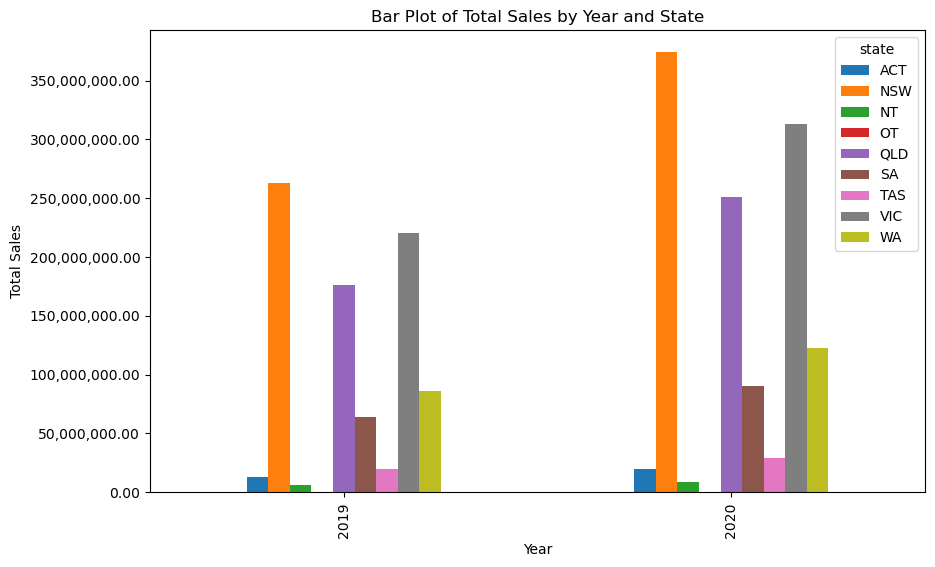

In [36]:
from pyspark.sql.functions import sum, col, year
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter


# extract the year from the sales timestamp
sales_with_year = sales_df.withColumn('year', year(col('sales_timestamp')))

# join user_df and sales_with_year using user id, and then group by state and year
# sum price based on groupped value
result_grouped = sales_with_year.join(user_df, on='user_id', how='inner')\
                                .groupBy('state', 'year')\
                                .agg(sum('price').alias('total_sales'))

# Select year, state and total sales or price
result_selected = result_grouped.select('year', 'state', 'total_sales')

# convert spark dataframe to pandas dataframe
result_pandas = result_selected.toPandas()

# pivot data with year as row, state as column and total sales as value
pivot_df = result_pandas.pivot(index='year', columns='state', values='total_sales')

# create a bar plot
plot=pivot_df.plot(kind='bar', figsize=(10, 6))

# set labels and title and format number for label
plt.xlabel('Year')
plt.ylabel('Total Sales')
plt.title('Bar Plot of Total Sales by Year and State')
plot.yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))


# show the bar plot
plt.show()


**2.2.6. Draw a scatter plot of customer age and their total spending with MOTH. To limit the number of datapoints, you may show the top 1000 “most valuable” customers only. You may also use log scale for the XY axis.**

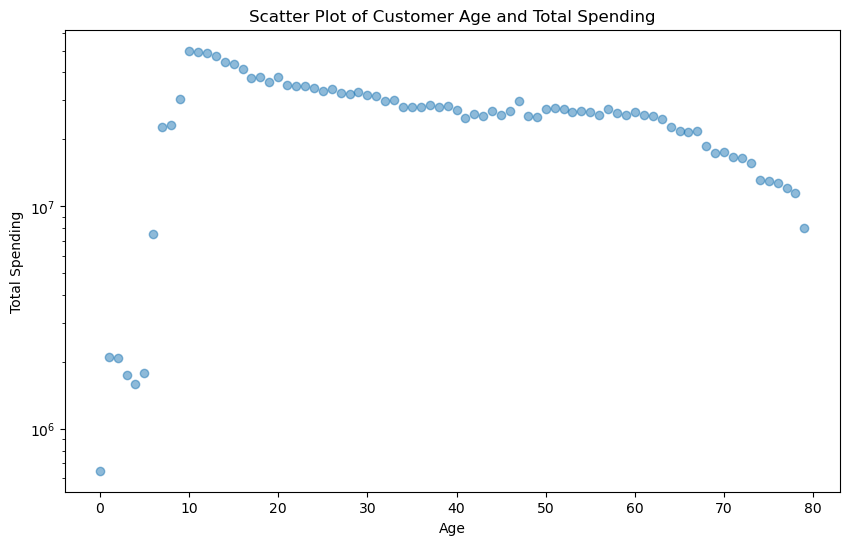

In [37]:
from pyspark.sql.functions import when, col,current_date,to_date,format_number
from pyspark.sql.functions import current_date, to_date, expr, floor,datediff,sum,unix_timestamp
import matplotlib.pyplot as plt

# calculate age (comparing current date-dob of the user)
user_df_with_age = user_df.withColumn(
    'age',
    floor(
        (unix_timestamp(current_date()) - unix_timestamp(to_date(user_df['dob'], 'd-M-y'))) /
        (365 * 24 * 60 * 60)
    )
)
# join sales dataframe with user df on previous lines using user id 
# then group the data by age and sum price 
result_grouped = sales_df.join(user_df_with_age, on='user_id', how='inner').groupBy('age')\
                         .agg(sum('price').alias('total_spending'))
  

# select age and total spending, order by total spending, limit 1000
result_formatted = result_grouped.select('age','total_spending').orderBy('total_spending', ascending=False).limit(1000)

# convert to panda for visualization
pandas_df = result_formatted.select('age', 'total_spending').toPandas()

# Create a scatter plot using Matplotlib
plt.figure(figsize=(10, 6))
plt.scatter(pandas_df['age'], pandas_df['total_spending'], alpha=0.5)
plt.xlabel('Age')
plt.ylabel('Total Spending')
plt.title('Scatter Plot of Customer Age and Total Spending')
plt.yscale('log')  # Use log scale for y-axis
# show the result
plt.show()



### Part 3 RDDs vs DataFrame vs Spark SQL (15%) <a class="anchor" name="part-3"></a>
Implement the following queries using RDDs, DataFrames in SparkSQL separately. Log the  time taken for each query in each approach using the “%%time” built-in magic command in Jupyter Notebook and discuss the performance difference between these 3 approaches. 


#### Query: Find top 100 most popular products (by total sales) among user age group 20-40, group by brand, and show total sales revenue of each brand.

#### 3.1. RDD Implementation

In [124]:
%%time
from datetime import datetime
from pyspark.sql.functions import to_date, unix_timestamp, date_format, current_date, floor, col, lit
# function to calculate age
def calculate_age(dob_str):
    dob = datetime.strptime(dob_str, '%d-%m-%Y')
    today = datetime.today()
    age = today.year - dob.year - ((today.month, today.day) < (dob.month, dob.day))
    return age


# join between sales rdd and user rdd using user id
joined_rdd = sales_rdd.map(lambda x: (x[4], x)).join(user_rdd.map(lambda x: (x[0], x)))

# Calculate age and filter based on the age criteria (20 <= age <= 40)
filtered_sales_rdd = joined_rdd.filter(lambda x: 20 <= (calculate_age(x[1][1][1])) <= 40)



# product_id,brand
product_brand_rdd = product_rdd.map(lambda x: (x[0], x[2]))
# Create key-value pairs (product_id,user_id,price)
product_price_rdd = filtered_sales_rdd.map(lambda x: ( x[1][0][2], x[1][0][3],x[1]))
# join that two key
brand_price_rdd = product_brand_rdd.join(product_price_rdd).map(lambda x: (x[1][0], x[1][1]))

# Use reduceByKey to sum the values for each key
brand_revenue_rdd = brand_price_rdd.map(lambda x: (x[0], float(x[1])))

# Use the reduceByKey transformation to group by the key ('') and sum the values
brand_revenue_rdd = brand_revenue_rdd.reduceByKey(lambda a, b: a + b)


# Sort by revenue in descending order
sorted_brands = brand_revenue_rdd.sortBy(lambda x: (x[1]), ascending=False)

# Take the top 100 best selling brands
top_100_brands = sorted_brands.take(100)


# Print the result (brand, total revenue)
for brand, revenue in top_100_brands:
    print(f"Brand: {brand}, Total Revenue: {revenue:,.2f}")




Brand: apple, Total Revenue: 588,769,713.00
Brand: samsung, Total Revenue: 252,809,526.18
Brand: , Total Revenue: 97,458,128.34
Brand: xiaomi, Total Revenue: 56,533,603.89
Brand: huawei, Total Revenue: 25,698,584.25
Brand: lg, Total Revenue: 23,305,170.56
Brand: lucente, Total Revenue: 17,763,440.94
Brand: sony, Total Revenue: 17,452,192.87
Brand: acer, Total Revenue: 16,941,223.91
Brand: oppo, Total Revenue: 16,795,346.08
Brand: lenovo, Total Revenue: 14,024,129.08
Brand: asus, Total Revenue: 8,219,573.72
Brand: hp, Total Revenue: 7,672,868.32
Brand: bosch, Total Revenue: 7,148,816.00
Brand: artel, Total Revenue: 6,046,806.13
Brand: indesit, Total Revenue: 5,305,313.22
Brand: haier, Total Revenue: 4,682,727.02
Brand: beko, Total Revenue: 3,460,183.91
Brand: dauscher, Total Revenue: 3,407,311.93
Brand: philips, Total Revenue: 2,719,130.11
Brand: vivo, Total Revenue: 2,682,159.02
Brand: midea, Total Revenue: 2,445,114.92
Brand: pulser, Total Revenue: 2,443,670.94
Brand: janome, Total Re

#### 3.2. DataFrame Implementation

In [39]:
%%time
from pyspark.sql.functions import when, col,current_date,to_date,format_number
from pyspark.sql.functions import current_date, to_date, expr, floor,datediff



# join user df with sales df and product td using user id and product id
# filter data based on user's age between 20 and 40
# group by brand 
# sum price
result_group = user_df_with_age.join(sales_df, on='user_id', how='inner') \
                               .join(product_df, on='product_id', how='inner') \
                               .filter((col('age') >= 20) & (col('age') <= 40)) \
                               .groupby('brand') \
                               .agg(sum(col('price')).alias('total_sales_temp'))
# select brand, total sales and order by total sales_temp 
result_group = result_group.orderBy('total_sales_temp', ascending=False) 

# rename column
result_group=result_group.withColumn(
    'total_sales', format_number(col('total_sales_temp'), 2)
).select('brand', 'total_sales')

# display result 
result_group.show(100)



+----------+--------------+
|     brand|   total_sales|
+----------+--------------+
|     apple|588,547,540.01|
|   samsung|252,844,774.56|
|      null| 97,471,593.82|
|    xiaomi| 56,540,697.18|
|    huawei| 25,685,443.55|
|        lg| 23,288,275.24|
|   lucente| 17,766,124.38|
|      sony| 17,472,357.12|
|      acer| 16,968,909.37|
|      oppo| 16,791,378.43|
|    lenovo| 14,047,650.73|
|      asus|  8,232,157.35|
|        hp|  7,677,390.84|
|     bosch|  7,150,487.54|
|     artel|  6,044,037.63|
|   indesit|  5,303,892.88|
|     haier|  4,683,005.98|
|      beko|  3,459,751.45|
|  dauscher|  3,411,107.87|
|   philips|  2,720,530.67|
|      vivo|  2,678,684.48|
|    pulser|  2,453,987.33|
|     midea|  2,443,129.57|
|    janome|  2,105,512.37|
|     tefal|  1,969,558.45|
|     canon|  1,879,685.78|
|   karcher|  1,855,153.94|
|       arg|  1,817,856.07|
| thermomix|  1,770,162.80|
|       tcl|  1,727,174.35|
|  dinastia|  1,691,949.64|
|   redmond|  1,670,743.37|
|     dyson|  1,596,

#### 3.3. Spark SQL Implementation

In [40]:
%%time
#  create a temporary view of the dataFrame that can be queried using sql

category_df.createOrReplaceTempView("sql_category")
user_df.createOrReplaceTempView("sql_user")
product_df.createOrReplaceTempView("sql_product")
sales_df.createOrReplaceTempView("sql_sales")
# join between sales, product, user and filter based on user's age between 20-40, group by brand
# order the result based on total sales desc , show only 100 data

df_sql = spark.sql('''
    select data.brand,
           format_number(data.total_sales,2) total_sales
          from (
    SELECT
        product.brand,
        sum(sales.price) AS total_sales
    FROM
        sql_product product
    JOIN
        sql_sales sales ON sales.product_id = product.product_id
    JOIN
        sql_user user ON sales.user_id = user.user_id
    where  floor((unix_timestamp(current_date()) - unix_timestamp(to_date(user.dob, 'd-M-y'))) / (365 * 24 * 60 * 60))
    between 20 and 40
    group by product.brand
    order by total_sales desc
    ) data
''')



df_sql.show(100)



+----------+--------------+
|     brand|   total_sales|
+----------+--------------+
|     apple|588,547,540.01|
|   samsung|252,844,774.56|
|      null| 97,471,593.82|
|    xiaomi| 56,540,697.18|
|    huawei| 25,685,443.55|
|        lg| 23,288,275.24|
|   lucente| 17,766,124.38|
|      sony| 17,472,357.12|
|      acer| 16,968,909.37|
|      oppo| 16,791,378.43|
|    lenovo| 14,047,650.73|
|      asus|  8,232,157.35|
|        hp|  7,677,390.84|
|     bosch|  7,150,487.54|
|     artel|  6,044,037.63|
|   indesit|  5,303,892.88|
|     haier|  4,683,005.98|
|      beko|  3,459,751.45|
|  dauscher|  3,411,107.87|
|   philips|  2,720,530.67|
|      vivo|  2,678,684.48|
|    pulser|  2,453,987.33|
|     midea|  2,443,129.57|
|    janome|  2,105,512.37|
|     tefal|  1,969,558.45|
|     canon|  1,879,685.78|
|   karcher|  1,855,153.94|
|       arg|  1,817,856.07|
| thermomix|  1,770,162.80|
|       tcl|  1,727,174.35|
|  dinastia|  1,691,949.64|
|   redmond|  1,670,743.37|
|     dyson|  1,596,

### 3.4 Observe the query execution time among RDD, DataFrame, SparkSQL, which is the fastest and why? (Maximum 500 words.)

Here is the query execution time.

For RDD
CPU times: user: 158 ms, sys: 85.1 ms, total: 243 ms
Wall time: 6min 7s

For Dataframe
CPU times: user 22.5 ms, sys: 4.04 ms, total: 26.5 ms
Wall time: 46.9 s

For Spark SQL
CPU times: user 6.56 ms, sys: 14 ms, total: 20.5 ms
Wall time: 54.2 s

CPU Time measures the time for the CPU to complete a task, while Wall Time measures the total elapsed time, including wait times.


In all three comparisons, Dataframe and SparkSQL are faster than RDD.
For Dataframe and Spark SQL, the time is almost the same.
Here are some reasons why Dataframe and Spark SQL are faster than RDD:

1.Dataframe and SparkSQL have a catalyst optimizer that can regenerate to create the most physical and logical query execution plan, which results in more efficiency and speed. However, RDD does not have that feature.
There are some steps in the catalyst optimizer.
This analysis rule will track the table and resolve the unresolved attributes, transforming the data source (unresolved logical plan) into a logical plan.
After that, it applied the optimisation rule to transform the logical plan into an optimised logical plan.
The logical plan describes computation on datasets without defining how to conduct the computation.
Based on that, it generates many physical plans.
The physical plan describes computation on datasets with specific definitions of how to conduct the computation.
The final step is code generation, which generates code for each machine and transforms it into RDDs.


2.Dataframe and Spark SQL have tungsten components, it maps your JVM object to tungsten internal memory.
There is a step called memory management and binary processing.
By serializing and deserializing JVM objects efficiently, and generating byte code, tungsten encoders enable JVM objects to be executed faster, avoiding garbage collection, taking up less space, and avoiding expensive Java serialization.


3.In this case, we use  functions such as avg, select, sum, and agg.
Dataframe and SparkSql are faster for creating aggregating functions compared to RDD.


As a result, Spark SQL and Data Frame are faster than RDD, but before making a decision, we should consider some factors, such as:

Use RDD when
If you want low-level transformation and action on your data,
Your data is unstructured, and you need high-level abstraction.
You do not care about schema (column name).
You do not care about optimisation and performance and want to use object-oriented programming.


Use Spark SQL and Dataframe when
You care about efficiency and optimisation.
You need to work on the column name and schema.
You need to work on aggregation functions (sum, average, etc.).


#### Summary

The time might differ when running on different machines. Overall, the DataFrame and SQL queries run ...... compared with RDD.


### Some ideas on the comparison

Armbrust, M., Huai, Y., Liang, C., Xin, R., & Zaharia, M. (2015). Deep Dive into Spark SQL’s Catalyst Optimizer. Retrieved September 30, 2017, from https://databricks.com/blog/2015/04/13/deep-dive-into-spark-sqls-catalyst-optimizer.html

Damji, J. (2016). A Tale of Three Apache Spark APIs: RDDs, DataFrames, and Datasets. Retrieved September 28, 2017, from https://databricks.com/blog/2016/07/14/a-tale-of-three-apache-spark-apis-rdds-dataframes-and-datasets.html

Data Flair (2017a). Apache Spark RDD vs DataFrame vs DataSet. Retrieved September 28, 2017, from http://data-flair.training/blogs/apache-spark-rdd-vs-dataframe-vs-dataset

Prakash, C. (2016). Apache Spark: RDD vs Dataframe vs Dataset. Retrieved September 28, 2017, from http://why-not-learn-something.blogspot.com.au/2016/07/apache-spark-rdd-vs-dataframe-vs-dataset.html

Xin, R., & Rosen, J. (2015). Project Tungsten: Bringing Apache Spark Closer to Bare Metal. Retrieved September 30, 2017, from https://databricks.com/blog/2015/04/28/project-tungsten-bringing-spark-closer-to-bare-metal.html